# Exploratory Data Analysis

In [49]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

In [50]:
# Load the data
data_path = os.getcwd() + "/data/"
train_df = pd.read_csv(data_path + "train.csv")
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [51]:
train_df.shape

(54706, 14)

In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [53]:
# Check for missing data
train_df.isnull().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

As we can see, there are a lot of missing values in the `BIRADS` and the `density` columns in the dataset. For `BIRADS`, we will replace the missing values with 0 - breast requires follow up, in case the `cancer` column is 1, else 1. For the `density` column, we can replace the missing values with either B/C as they are the predominant values for that category.

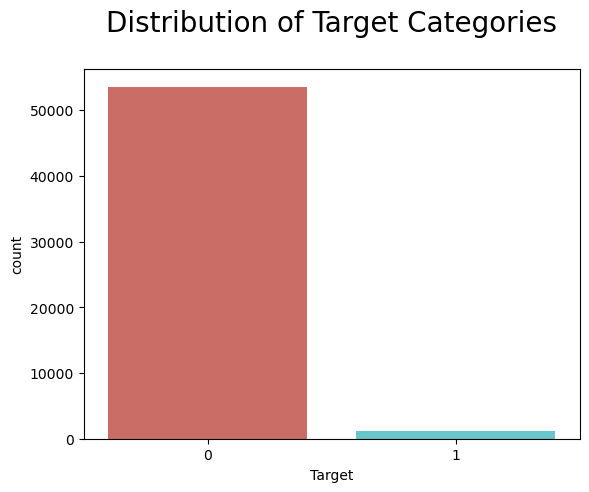

In [54]:
# Check the distribution of data
sns.countplot(x = train_df["cancer"], palette = "hls")
plt.xlabel("Target")
plt.title('Distribution of Target Categories', fontsize=20, y=1.08)
plt.show()

In the above plot, we can observe that the data is very skewed and we will need to upsample it before processing it in order to get more accurate classifications.

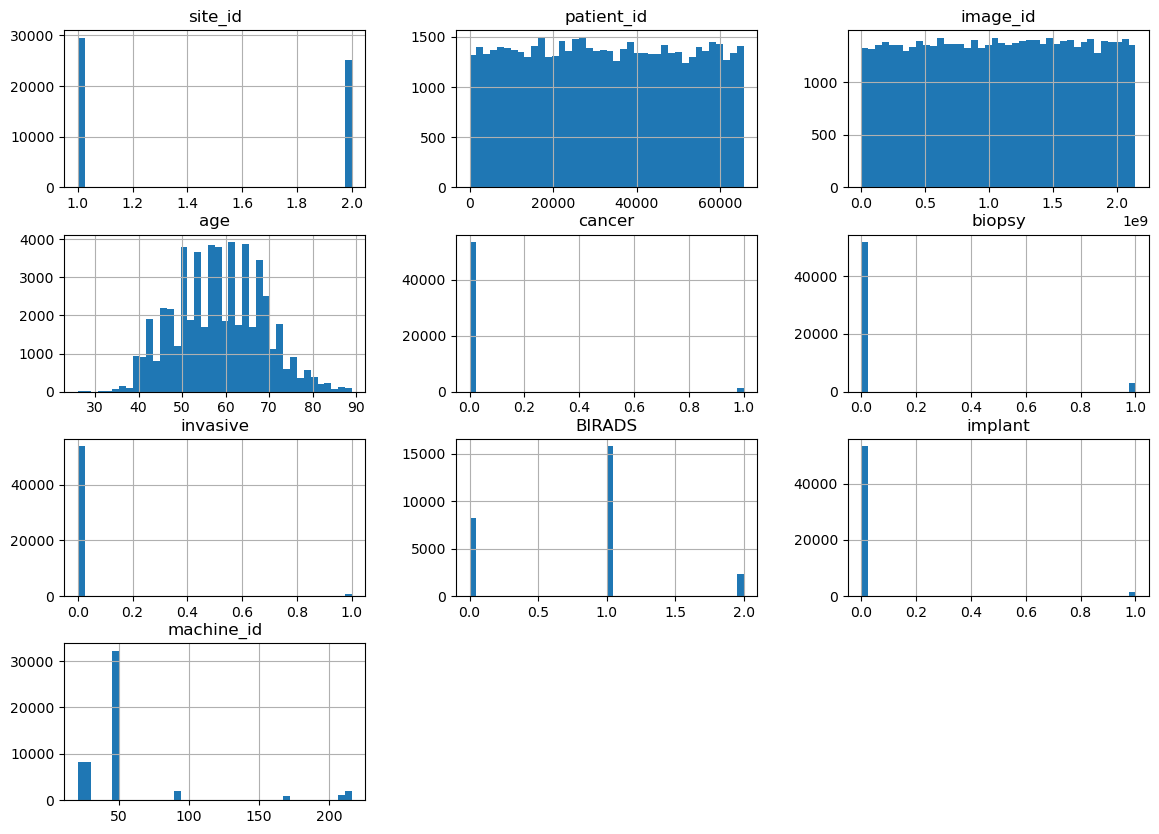

In [55]:
# Check the distribution data for all variables
train_df.hist(bins = 40, figsize = (14,10))
plt.show()

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/354593848.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_corr_mat = train_df.corr()


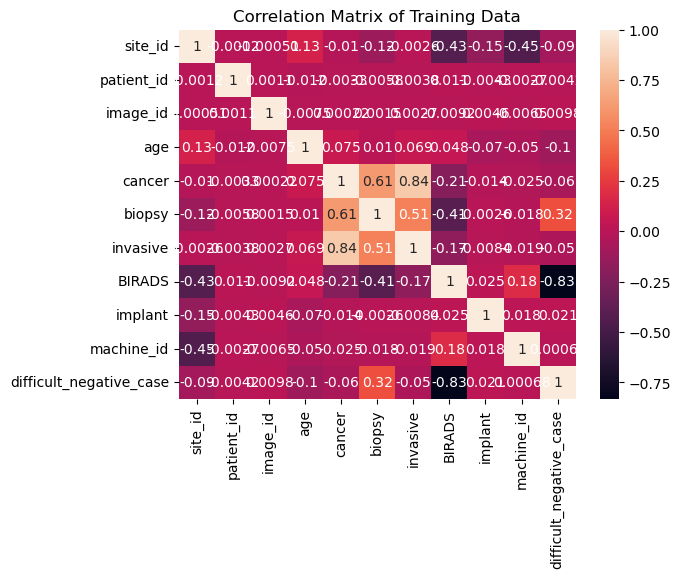

In [56]:
# Plot a correlation matrix wrt to the target variable
train_corr_mat = train_df.corr()
sns.heatmap(train_corr_mat, annot=True)
plt.title("Correlation Matrix of Training Data")
plt.show()

In [57]:
corr_target = train_df.corr()['cancer']
corr_target

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/3383055614.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_target = train_df.corr()['cancer']


site_id                   -0.009975
patient_id                -0.003253
image_id                   0.000223
age                        0.075155
cancer                     1.000000
biopsy                     0.613872
invasive                   0.837815
BIRADS                    -0.210718
implant                   -0.014311
machine_id                -0.024888
difficult_negative_case   -0.059541
Name: cancer, dtype: float64

We can see that there is a strong positive correlation between `cancer`, the target variable and `invasive` and `biopsy` data.

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/1915376753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df.loc[:, 'count'] = 1


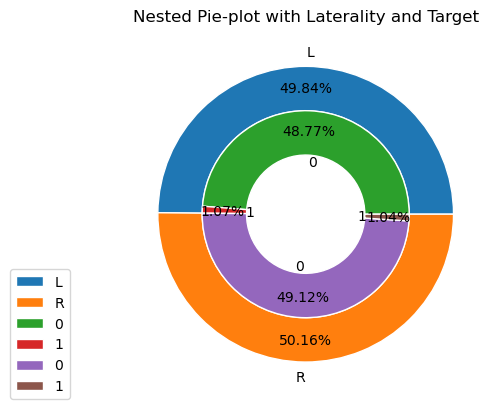

In [58]:
# Visualize Laterality distribution w.r.t. Target
visual_df = train_df[["cancer", "laterality"]]
visual_df.loc[:, 'count'] = 1
outer = visual_df.groupby("laterality").count()
inner = visual_df.groupby(["laterality", "cancer"]).count()
fig, ax = plt.subplots()
size = 0.3

ax.pie(outer['count'].values.flatten(), radius=1,
       labels=outer.index,
       autopct='%.2f%%',
       labeldistance=1.1,
       pctdistance = 0.85,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner.index.get_level_values(1),
       labeldistance=0.5,
       autopct='%.2f%%',
       pctdistance=0.8,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Nested Pie-plot with Laterality and Target')
plt.legend(loc=(-0.3, 0))
plt.show()

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/2650305267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df.loc[:, 'count'] = 1


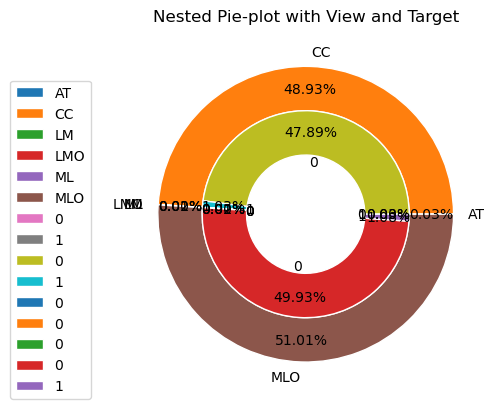

In [59]:
# Visualize View distribution w.r.t. Target
visual_df = train_df[["cancer", "view"]]
visual_df.loc[:, 'count'] = 1
outer = visual_df.groupby("view").count()
inner = visual_df.groupby(["view", "cancer"]).count()
fig, ax = plt.subplots()
size = 0.3

ax.pie(outer['count'].values.flatten(), radius=1,
       labels=outer.index,
       autopct='%.2f%%',
       labeldistance=1.1,
       pctdistance = 0.85,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner.index.get_level_values(1),
       labeldistance=0.5,
       autopct='%.2f%%',
       pctdistance=0.8,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Nested Pie-plot with View and Target')
plt.legend(loc=(-0.3, 0))
plt.show()

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/2954279708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df.loc[:, 'count'] = 1


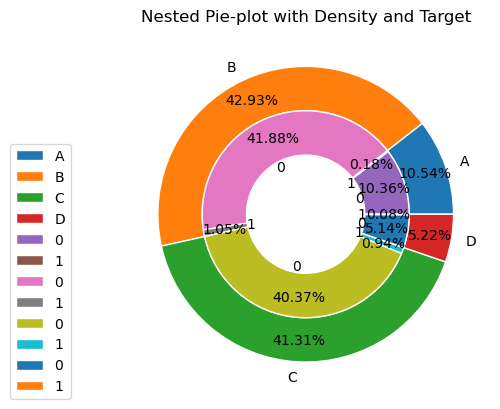

In [60]:
# Visualize Density distribution w.r.t. Target
visual_df = train_df[["cancer", "density"]]
visual_df.loc[:, 'count'] = 1
outer = visual_df.groupby("density").count()
inner = visual_df.groupby(["density", "cancer"]).count()
fig, ax = plt.subplots()
size = 0.3

ax.pie(outer['count'].values.flatten(), radius=1,
       labels=outer.index,
       autopct='%.2f%%',
       labeldistance=1.1,
       pctdistance = 0.85,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner.index.get_level_values(1),
       labeldistance=0.5,
       autopct='%.2f%%',
       pctdistance=0.8,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Nested Pie-plot with Density and Target')
plt.legend(loc=(-0.3, 0))
plt.show()

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/4065317061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df.loc[:, 'count'] = 1


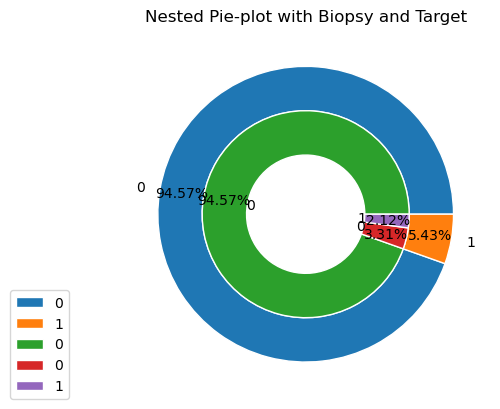

In [61]:
# Visualize Biopsy distribution w.r.t. Target
visual_df = train_df[["cancer", "biopsy"]]
visual_df.loc[:, 'count'] = 1
outer = visual_df.groupby("biopsy").count()
inner = visual_df.groupby(["biopsy", "cancer"]).count()
fig, ax = plt.subplots()
size = 0.3

ax.pie(outer['count'].values.flatten(), radius=1,
       labels=outer.index,
       autopct='%.2f%%',
       labeldistance=1.1,
       pctdistance = 0.85,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner.index.get_level_values(1),
       labeldistance=0.5,
       autopct='%.2f%%',
       pctdistance=0.8,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Nested Pie-plot with Biopsy and Target')
plt.legend(loc=(-0.3, 0))
plt.show()

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/281590283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df.loc[:, 'count'] = 1


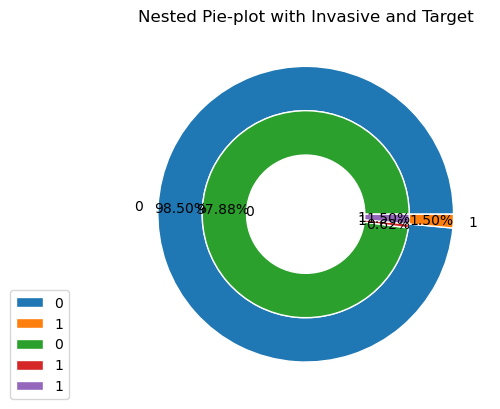

In [62]:
# Visualize Invasive distribution w.r.t. Target
visual_df = train_df[["cancer", "invasive"]]
visual_df.loc[:, 'count'] = 1
outer = visual_df.groupby("invasive").count()
inner = visual_df.groupby(["invasive", "cancer"]).count()
fig, ax = plt.subplots()
size = 0.3

ax.pie(outer['count'].values.flatten(), radius=1,
       labels=outer.index,
       autopct='%.2f%%',
       labeldistance=1.1,
       pctdistance = 0.85,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner.index.get_level_values(1),
       labeldistance=0.5,
       autopct='%.2f%%',
       pctdistance=0.8,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Nested Pie-plot with Invasive and Target')
plt.legend(loc=(-0.3, 0))
plt.show()

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/1545647116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df.loc[:, 'count'] = 1


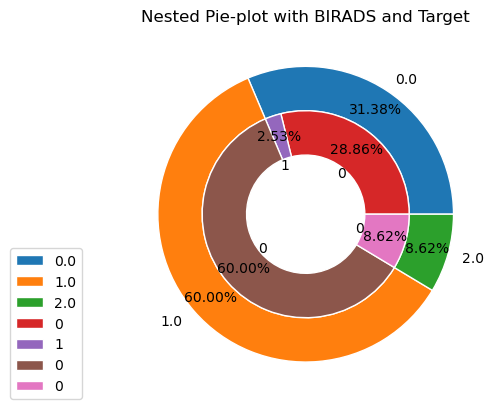

In [63]:
# Visualize BIRADS distribution w.r.t. Target
visual_df = train_df[["cancer", "BIRADS"]]
visual_df.loc[:, 'count'] = 1
outer = visual_df.groupby("BIRADS").count()
inner = visual_df.groupby(["BIRADS", "cancer"]).count()
fig, ax = plt.subplots()
size = 0.3

ax.pie(outer['count'].values.flatten(), radius=1,
       labels=outer.index,
       autopct='%.2f%%',
       labeldistance=1.1,
       pctdistance = 0.85,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner.index.get_level_values(1),
       labeldistance=0.5,
       autopct='%.2f%%',
       pctdistance=0.8,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Nested Pie-plot with BIRADS and Target')
plt.legend(loc=(-0.3, 0))
plt.show()

/var/folders/f1/p2302xs91xlc774x8zkltzqh0000gn/T/ipykernel_68048/1798956484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df.loc[:, 'count'] = 1


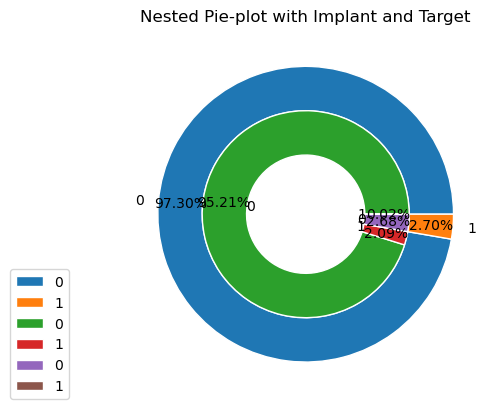

In [64]:
# Visualize Implant distribution w.r.t. Target
visual_df = train_df[["cancer", "implant"]]
visual_df.loc[:, 'count'] = 1
outer = visual_df.groupby("implant").count()
inner = visual_df.groupby(["implant", "cancer"]).count()
fig, ax = plt.subplots()
size = 0.3

ax.pie(outer['count'].values.flatten(), radius=1,
       labels=outer.index,
       autopct='%.2f%%',
       labeldistance=1.1,
       pctdistance = 0.85,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner.index.get_level_values(1),
       labeldistance=0.5,
       autopct='%.2f%%',
       pctdistance=0.8,
       wedgeprops = dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Nested Pie-plot with Implant and Target')
plt.legend(loc=(-0.3, 0))
plt.show()

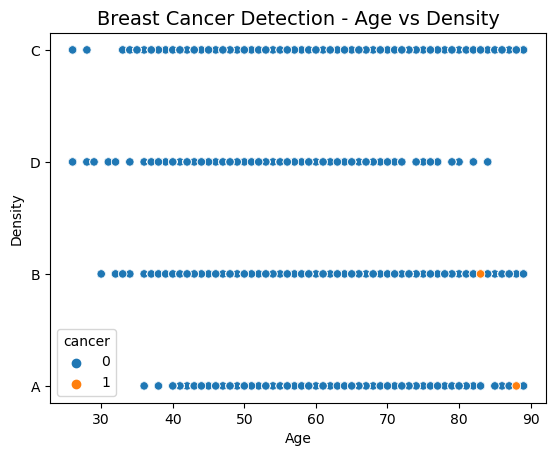

In [65]:
# Age vs Density Scatterplot
sns.scatterplot(data=train_df, x='age', y='density', hue='cancer')
plt.title('Breast Cancer Detection - Age vs Density', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

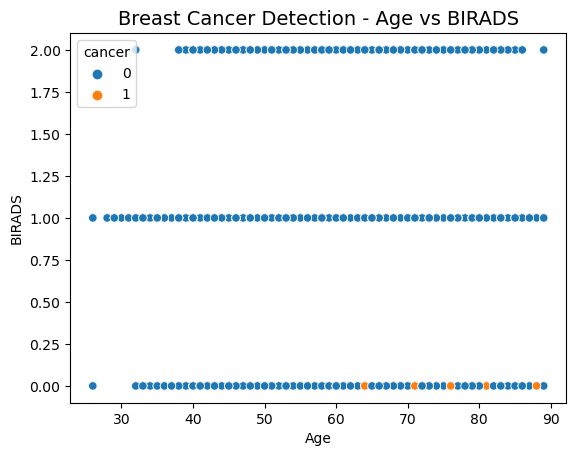

In [66]:
# Age vs BIRADS Scatterplot
sns.scatterplot(data=train_df, x='age', y='BIRADS', hue='cancer')
plt.title('Breast Cancer Detection - Age vs BIRADS', fontsize=14)
plt.xlabel('Age')
plt.ylabel('BIRADS')
plt.show()

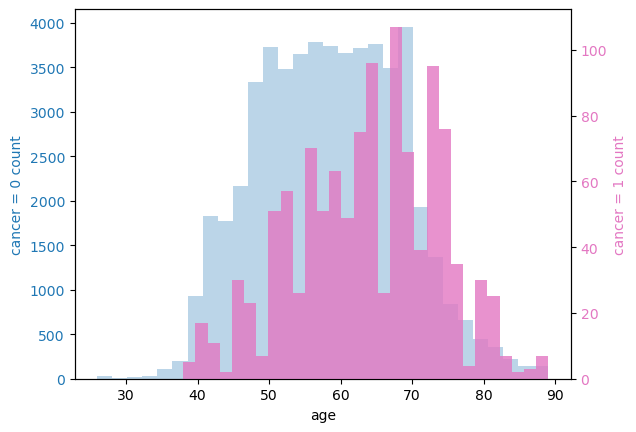

In [67]:
# Target variable over age distribution
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('age')
ax1.set_ylabel('cancer = 0 count', color= color)
ax1.hist(train_df.loc[train_df['cancer'] == 0, 'age'].dropna(), bins = 30, alpha = 0.3, label = '0', color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:pink'
ax2.set_ylabel('cancer = 1 count', color=color) 
ax2.hist(train_df.loc[train_df['cancer'] == 1, 'age'].dropna(), bins=30, alpha=0.8, label='1', color=color)
ax2.tick_params(axis='y', labelcolor=color)
 
plt.show()

# Data Preprocessing

In [68]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [69]:
train_df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


In [70]:
# Only taking specific columns
train_df = train_df[["patient_id", "image_id", "laterality", "view", "age",'implant','machine_id','biopsy' ,"invasive", "cancer"]]
train_df.head()

,patient_id,image_id,laterality,view,age,implant,machine_id,biopsy,invasive,cancer
0,10006,462822612,L,CC,61.0,0,29,0,0,0
1,10006,1459541791,L,MLO,61.0,0,29,0,0,0
2,10006,1864590858,R,MLO,61.0,0,29,0,0,0
3,10006,1874946579,R,CC,61.0,0,29,0,0,0
4,10011,220375232,L,CC,55.0,0,21,0,0,0


In [71]:
train_df.isna().sum()

patient_id     0
image_id       0
laterality     0
view           0
age           37
implant        0
machine_id     0
biopsy         0
invasive       0
cancer         0
dtype: int64

In [72]:
# Replacing missing values in age
train_df['age'] = train_df['age'].fillna(round(train_df['age'].mean()))

In [73]:
# Applying LabelEncoder on the categorical columns

le_laterality = LabelEncoder()
le_view = LabelEncoder()

train_df['laterality'] = le_laterality.fit_transform(train_df['laterality'])
train_df['view'] = le_view.fit_transform(train_df['view'])

train_df.head()

,patient_id,image_id,laterality,view,age,implant,machine_id,biopsy,invasive,cancer
0,10006,462822612,0,1,61.0,0,29,0,0,0
1,10006,1459541791,0,5,61.0,0,29,0,0,0
2,10006,1864590858,1,5,61.0,0,29,0,0,0
3,10006,1874946579,1,1,61.0,0,29,0,0,0
4,10011,220375232,0,1,55.0,0,21,0,0,0


In [74]:
train_df.isna().sum()

patient_id    0
image_id      0
laterality    0
view          0
age           0
implant       0
machine_id    0
biopsy        0
invasive      0
cancer        0
dtype: int64

# Random Forest Classifier

In [75]:
# Divide the data into train and test
X = train_df.drop('cancer', axis=1)
y = train_df['cancer']

In [76]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [77]:
# Fit the Random Forest Classifier on training data
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [78]:
# Test the Classifier
y_pred = rf_clf.predict(X_test)

In [79]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1 score:", F1_score)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9951562785596783
F1 score: 0.8579088471849866
Precision: 0.9580838323353293
Recall: 0.7766990291262136
